# **Importing Libraries**

In [1]:
import numpy as np 
import cv2
import os
import matplotlib.pyplot as plt

import torchvision, torch
from torchsummary import summary
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import copy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# **Unzip the Test Folder**

In [23]:
PATH_TO_TEST_FOLDER = '/content/drive/MyDrive/Image\ Colorizer/Images/test.zip'
!unzip $PATH_TO_TEST_FOLDER

Archive:  /content/drive/MyDrive/Image Colorizer/Images/test.zip
replace test/download (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Function to get Grayscale version of ground truth image or Input image

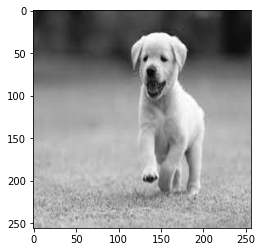

In [7]:
def get_grayscale(path):

    img = cv2.imread(path, 0)
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
    img = img.reshape(256, 256, 1).astype(float) /255.0
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img

gray = get_grayscale(img_loc).detach().numpy().reshape((256, 256))
plt.imshow(gray, cmap = 'gray')

### Function to convert Lab Image to RGB

In [8]:
def lab2rgb(img):

    l,a,b = cv2.split(img)
    l = l*100.0
    a = a*255.0 - 128
    b = b*255.0 - 128
    lab = cv2.merge([l,a,b])
    rgb = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
    return rgb


### Function to obtain LAB image from image path

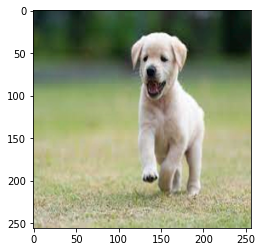

In [9]:
def get_lab(path):

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
    img = img.reshape(256, 256, 3).astype(float) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img

lab = get_lab(img_loc).detach().permute(1, 2, 0).numpy()
rgb = lab2rgb(lab)
plt.imshow(rgb)

Function to extract "AB" channel from "LAB" image

In [10]:
def get_ab(path):
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
    img = img.reshape(256, 256, 3).astype(float) / 255.0
    img = img[:,:,1:]
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img
    
get_ab(img_loc)

tensor([[[0.4745, 0.4745, 0.4745,  ..., 0.4706, 0.4706, 0.4706],
         [0.4745, 0.4745, 0.4745,  ..., 0.4706, 0.4706, 0.4706],
         [0.4745, 0.4745, 0.4745,  ..., 0.4706, 0.4706, 0.4706],
         ...,
         [0.4902, 0.4902, 0.4863,  ..., 0.4353, 0.4392, 0.4353],
         [0.4980, 0.4941, 0.4941,  ..., 0.4353, 0.4392, 0.4353],
         [0.4980, 0.4941, 0.4941,  ..., 0.4314, 0.4392, 0.4353]],

        [[0.5020, 0.5020, 0.5020,  ..., 0.5137, 0.5137, 0.5137],
         [0.5020, 0.5020, 0.5020,  ..., 0.5137, 0.5137, 0.5137],
         [0.4980, 0.4980, 0.4980,  ..., 0.5137, 0.5137, 0.5137],
         ...,
         [0.5569, 0.5569, 0.5647,  ..., 0.6118, 0.6039, 0.6039],
         [0.5608, 0.5647, 0.5686,  ..., 0.6078, 0.6039, 0.6039],
         [0.5608, 0.5647, 0.5686,  ..., 0.6039, 0.6000, 0.6000]]])

Function to plot predictions

In [1]:
def plot_pred(y0, y1, y2):

    n = y0.shape[0]
    fig, ax = plt.subplots(n, 3, figsize = (15, 5*n))

    for i in range(y0.shape[0]):
        gray = y0[i]
        ab = y1[i]
        lab_act = y2[i]

        lab_pred = combine(gray, ab)

        gray = gray.reshape((256, 256))
        lab_pred = lab2rgb(lab_pred)
        lab_act = lab2rgb(lab_act)

        ax[i][0].imshow(gray, cmap = 'gray')
        ax[i][0].set_title('Input - Gray')
        ax[i][0].axis('off')
        
        ax[i][1].imshow(lab_pred)
        ax[i][1].set_title('Prediction')
        ax[i][1].axis('off')

        ax[i][2].imshow(lab_act)
        ax[i][2].set_title('Actual')
        ax[i][2].axis('off')

    return 0


Function to combine channels of image

In [12]:
def combine(l, ab):
    img = np.concatenate((l, ab), axis = -1)
    return img

# l = np.random.rand(4, 256, 256, 1)
# ab = np.random.rand(4, 256, 256, 2)
# combine(l, ab).shape

(4, 256, 256, 3)

In [14]:
class ImagesDatasetTest(Dataset):

    """
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ColorJitter(brightness=(0.2,0.8), contrast=(0.2,0.8)),
                                    transforms.ToTensor()])
    """

    def __init__(self, img_dir, transform = []):
        
        self.img_dir = img_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):

        self.path = os.path.join(self.img_dir, self.img_files[idx])
        x = get_grayscale(self.path)
        y = get_lab(self.path)

        return x,y

In [15]:
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
    
        def encode_layer(inp, out, kernel = 3, stride = 1, padding = 0, dilation = 1):
            return nn.Sequential(
                nn.Conv2d(inp, out, kernel, stride, padding, dilation),
                nn.BatchNorm2d(out),
                nn.SELU(True)
            )

        def decode_layer(inp, out, kernel = 3, stride = 1, padding = 0):
            return nn.Sequential(
                nn.ConvTranspose2d(inp, out, kernel, stride, padding),
                nn.BatchNorm2d(out),
                nn.SELU(True)
            )
        
        self.encoder = nn.Sequential(
            encode_layer(1, 64),
            encode_layer(64, 64),
            encode_layer(64, 128),
            encode_layer(128, 256),
            encode_layer(256, 512)
        )

        self.decoder = nn.Sequential(
            decode_layer(512, 256),
            decode_layer(256, 128),
            decode_layer(128, 64),
            decode_layer(64, 32),
            decode_layer(32, 2)
        )

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [16]:
# link https://drive.google.com/file/d/17bOZ2RVUE9TQn0verKm6ZDlsA9-plzGv/view?usp=sharing
!gdown --id 17bOZ2RVUE9TQn0verKm6ZDlsA9-plzGv

Downloading...
From: https://drive.google.com/uc?id=17bOZ2RVUE9TQn0verKm6ZDlsA9-plzGv
To: /content/modelv2.pth
100% 12.7M/12.7M [00:00<00:00, 59.2MB/s]


In [17]:
PATH = 'modelv2.pth'
model = ColorNet().to(device)
model.load_state_dict(copy.deepcopy(torch.load(PATH, device)))
model.eval()

ColorNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, mo

(10, 256, 256, 3)
(1.0, 0.0) (1.0, 0.0)


(108.12954614720252, 1081.2954614720252)

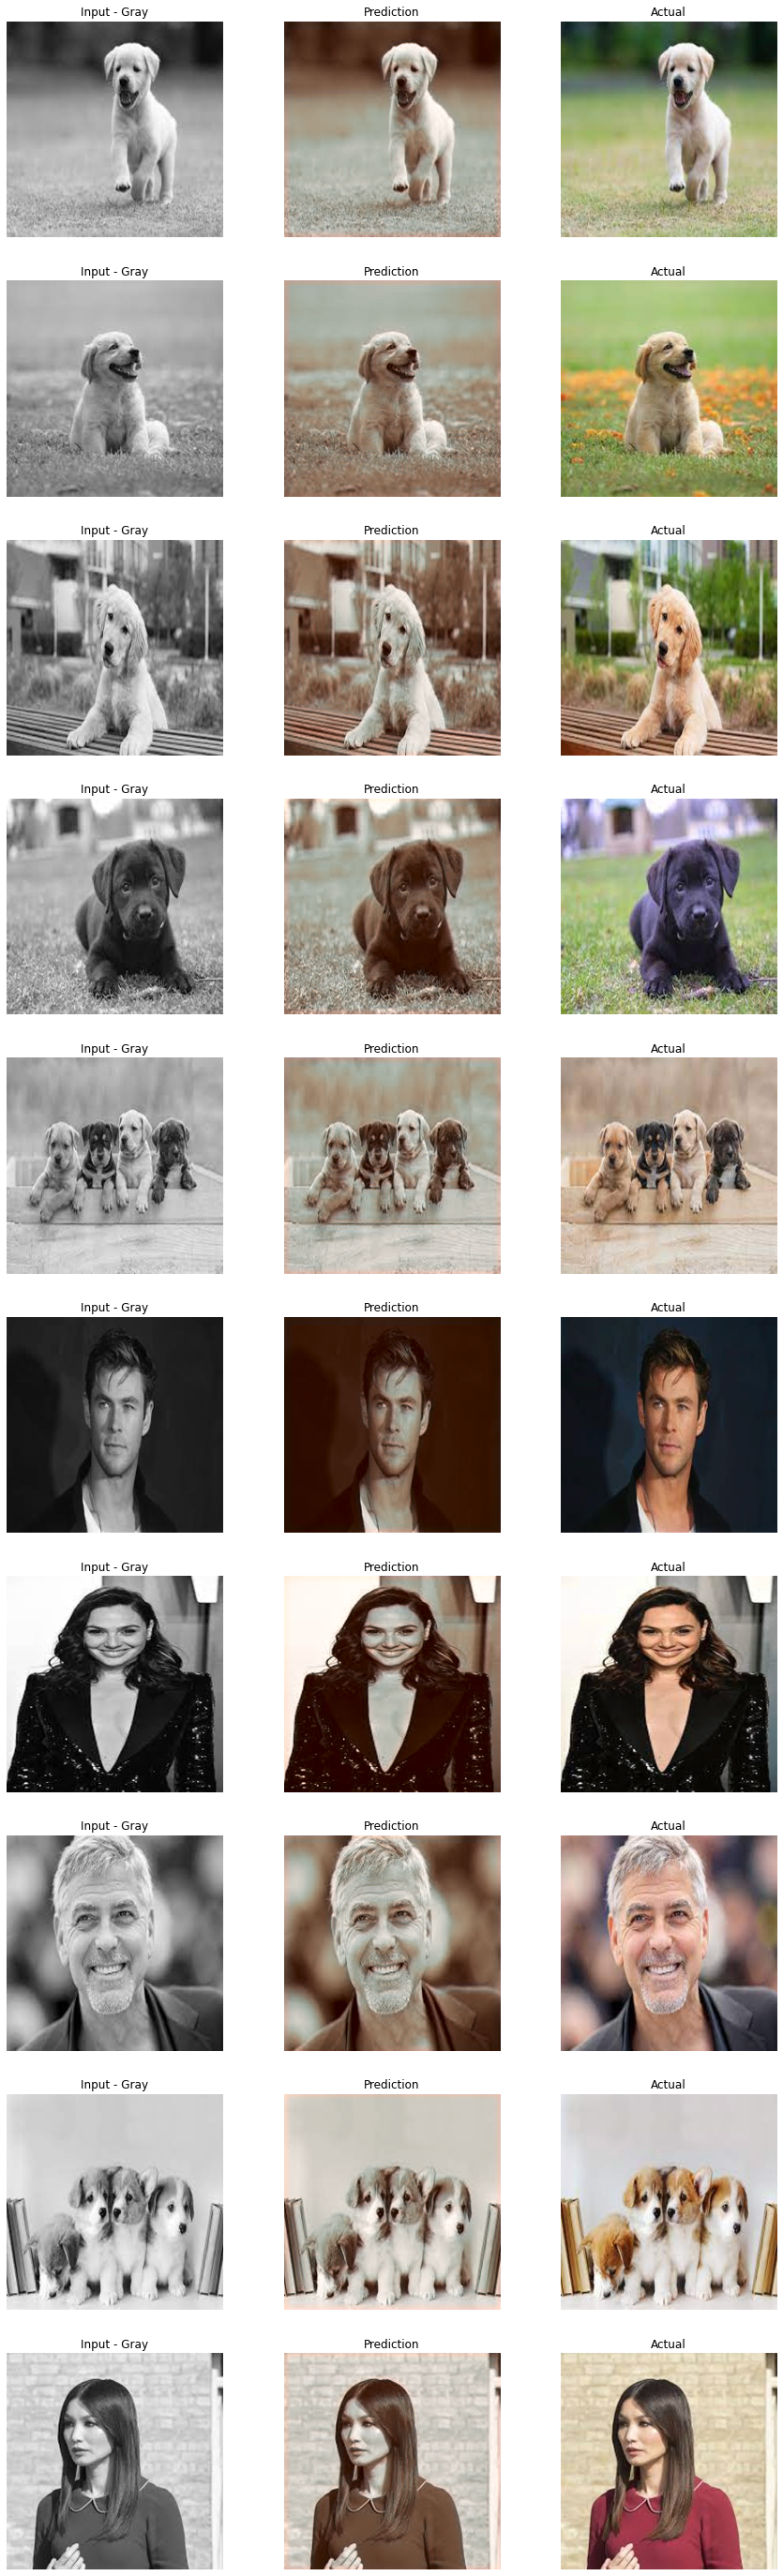

In [20]:
dataset = ImagesDatasetTest('test')
loader = DataLoader(dataset, batch_size = 16, shuffle = False, num_workers=2)

total_loss = 0
num = 0
preds = []
for i, (gray, lab) in enumerate(loader):

    # print(gray)
    gray = gray.to(device)
    pred = model(gray)

    pred = pred.permute(0, 2, 3, 1).detach().cpu().numpy()
    # print(pred.shape)

    gray = gray.permute(0, 2, 3, 1).detach().cpu().numpy()
    # print(gray.shape)

    lab = lab.permute(0, 2, 3, 1).detach().cpu().numpy()
    print(lab.shape)

    
    num += gray.shape[0]

    plot_pred_ab(gray, pred, lab)
    lab_pred = combine(gray, pred)
    print((np.max(lab), np.min(lab)), (np.max(lab_pred), np.min(lab_pred)))
    loss = np.sum((lab_pred - lab)**2)**0.5*16
    total_loss += loss

    break

total_loss/num, total_loss